<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_lesson5_mnist_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

In [2]:
!ls mnist.pkl.gz > /dev/null || wget http://deeplearning.net/data/mnist/mnist.pkl.gz

ls: cannot access 'mnist.pkl.gz': No such file or directory
--2019-02-10 18:36:55--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.05MB/s    in 4.5s    

2019-02-10 18:37:01 (3.39 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [3]:
!ls mnist.pkl > /dev/null || gunzip mnist.pkl.gz

ls: cannot access 'mnist.pkl': No such file or directory


In [0]:
import pickle
res = pickle.load(open('mnist.pkl', 'rb'), encoding='latin-1')

In [5]:
type(res), len(res)

(tuple, 3)

In [6]:
[(type(t), len(t)) for t in res]

[(tuple, 2), (tuple, 2), (tuple, 2)]

In [7]:
[(x.shape, y.shape) for (x,y) in res]

[((50000, 784), (50000,)), ((10000, 784), (10000,)), ((10000, 784), (10000,))]

In [0]:
train, test, valid = [TensorDataset(tensor(x), tensor(y)) for (x,y) in res]

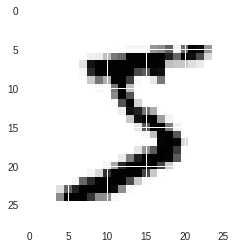

In [9]:
IMAGE = 0
LABEL = 1
import matplotlib.pyplot as plt
plt.imshow(train[0][IMAGE].reshape(28,28))

In [10]:
sorted(test.tensors[LABEL].unique().numpy())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
batch_size = 64
data = DataBunch.create(train, valid, bs=batch_size)

In [12]:
data.show_batch()

AttributeError: ignored

In [13]:
images,labels = next(iter(data.train_dl))
images.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.linear1 = nn.Linear(784, 50, bias=True)
    self.linear2 = nn.Linear(50, 10, bias=True)
    # Note to self: not doing .data spits an error about Leaf var modification
    # Note to self: built-in init works much better then mine (loss of 2 vs 2k)
    #self.linear1.weight.data.uniform_(0.01)
    #self.linear2.weight.data.uniform_(0.01)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    return x

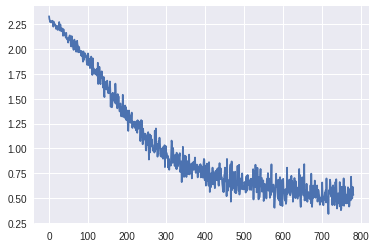

In [100]:
model = MyModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.02, weight_decay=0.01)

wd=0.01

def update(x,y):
  optimizer.zero_grad()
  y_probabilities = model(x)
  loss = criterion(y_probabilities, target=y)
  loss_val = loss.item()
  loss.backward()
  optimizer.step()
  return loss_val

plt.plot([update(x, y) for (x, y) in data.train_dl])

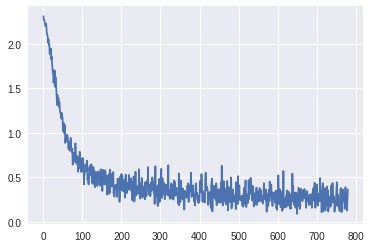

In [104]:
model = MyModel().cuda()
# Note to self: there's litterally no difference between this and Adam optimizer initialized in the cycle of update as in original notebook
# TODO: who's the one maintaining the history of the moments between the batches, or it doesn't matter much
optimizer = optim.Adam(lr=1e-3, params=model.parameters())

def update(x,y):
  optimizer.zero_grad()
  y_probabilities = model(x)
  loss = criterion(y_probabilities, target=y)
  loss_val = loss.item()
  loss.backward()
  optimizer.step()
  return loss_val

plt.plot([update(x, y) for (x, y) in data.train_dl])

In [0]:
learner = Learner(data, MyModel(), loss_func=criterion, metrics=accuracy)

In [112]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


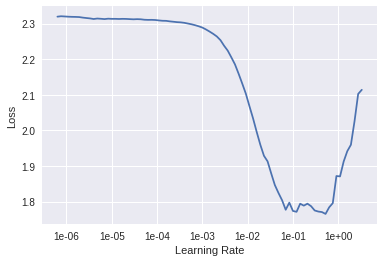

In [113]:
learner.recorder.plot()

In [114]:
from fastai.callbacks import SaveModelCallback
savemodel = SaveModelCallback(learner, name='v1')
learner.fit_one_cycle(5, 1e-2, callbacks=[savemodel])

epoch,train_loss,valid_loss,accuracy
1,0.248514,0.200738,0.938500
2,0.155898,0.183138,0.947000
3,0.116186,0.110573,0.967600
4,0.060875,0.093674,0.973300
5,0.038927,0.083483,0.975300
